Exploration of the E14.5 time point in the pancreas
----
At one reviewers request, we're exploring one of the earlier timepoints in our pancreas data. 

# Preliminaries

## Dependecy notebooks

## Import packages

If you want modules to be automatically reloaded when you call them, use `autoreload`:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
gpu=False

Import packages

In [3]:
import anndata
import networkx as nx
import scanpy as sc
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cellrank as cr
import scipy.sparse

In [4]:
if gpu:
    import scglue # only works with gpu

In [5]:
sc.set_figure_params(figsize=(4,4), dpi=120)

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [6]:
cr.logging.print_versions()

cellrank==1.5.1 scanpy==1.9.1 anndata==0.8.0 numpy==1.22.4 numba==0.55.2 scipy==1.9.0 pandas==1.4.3 pygpcca==1.0.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.5.2 seaborn==0.11.2


In [7]:
cr.logging.print_version_and_date()

Running CellRank 1.5.1, on 2022-10-16 20:12.


## Setup paths

In [8]:
data_path = '/lustre/groups/ml01/workspace/laura.martens/moretti_colab'
save_path = os.path.join(data_path, 'scglue')

# Glue analysis

## Load raw data

In [26]:
rna = anndata.read(os.path.join(data_path, "transfer_data", "Day2_15_RNAseq.h5ad"))
rna

AnnData object with n_obs × n_vars = 35499 × 24353
    obs: 'clusters', 'day'
    var: 'gene'

In [30]:
rna.X = scipy.sparse.csr_matrix(rna.X)

In [405]:
atac = anndata.read_h5ad(os.path.join(data_path, 'signac', 'adata_peaks_unfiltered.h5ad'))
atac


AnnData object with n_obs × n_vars = 27027 × 162003
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'passed_filters', 'duplicate', 'cell_id', 'is__cell_barcode', 'TSS.enrichment', 'TSS.percentile', 'nucleosome_signal', 'nucleosome_percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'doublet_qvalue', 'is_doublet', 'peaks_snn_res.0.8', 'seurat_clusters', 'sample', 'nCount_RNA', 'nFeature_RNA'
    uns: 'gene_names', 'motif_names'
    obsm: 'activities', 'chromvar', 'lsi_full', 'lsi_red', 'umap'

## Preprocess scRNA-seq data

In [32]:
rna.layers["counts"] = rna.X.copy()

In [33]:
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")

In [34]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)

In [36]:
#save unscaled counts
rna.layers["log_counts"] = rna.X.copy()

In [37]:
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

In [38]:
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)

In [39]:
rna.obs.clusters=rna.obs.clusters.astype(str)

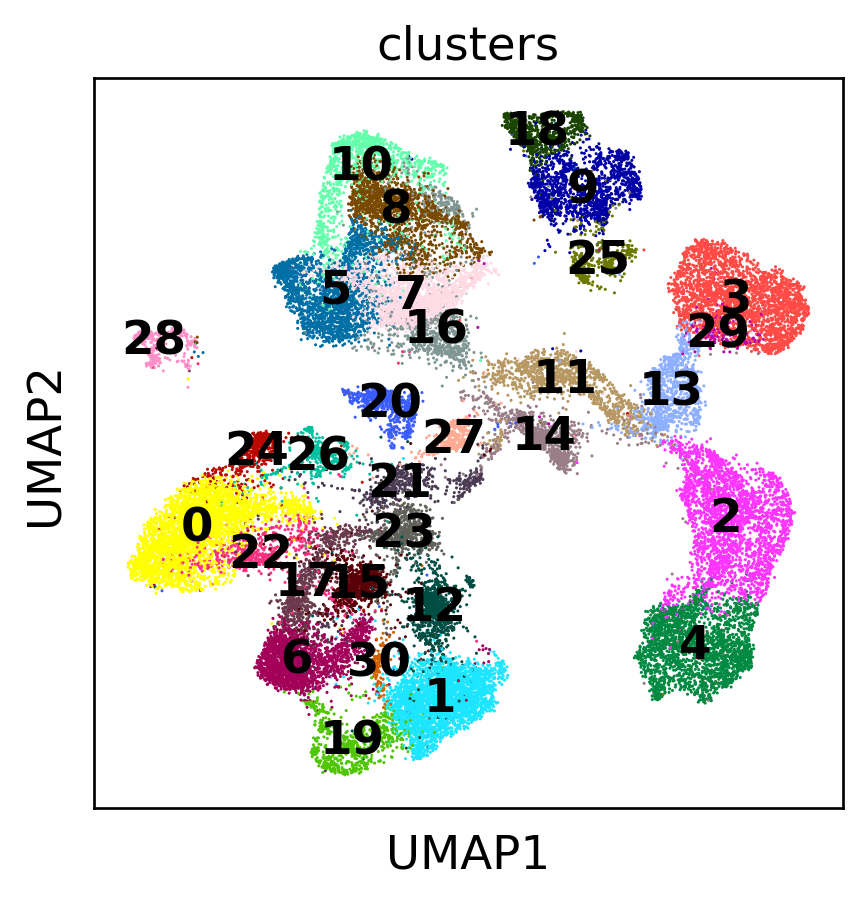

In [40]:
sc.pl.umap(rna, color="clusters", legend_loc='on data')

In [41]:
7

7

## Preprocess scATAC-seq data

In [406]:
scglue.data.lsi(atac, n_components=101, n_iter=15)

In [407]:
# remove first column as it is normally correlated with 
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:, 1:]

In [408]:
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")

In [409]:
sc.tl.umap(atac)

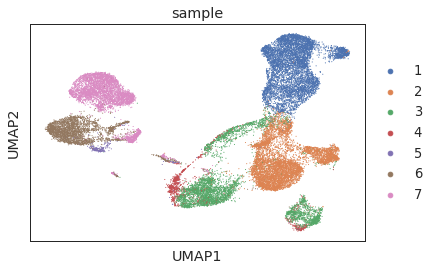

In [410]:
sc.pl.umap(atac, color="sample")

## Construct prior regulatory graph

In [42]:
rna.var = rna.var.iloc[:, :8].copy()

In [43]:
scglue.data.get_gene_annotation(
    rna, gtf="/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/gencode.v19.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)

In [44]:
# Drop unmatched genes
rna = rna[:, ~rna.var.chrom.isna()].copy()

In [411]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1])
atac.var["chromEnd"] = split.map(lambda x: x[2])
atac.var.head()

chrom chromStart chromEnd
chr1-237564-237942  chr1     237564   237942
chr1-521393-521767  chr1     521393   521767
chr1-565108-565548  chr1     565108   565548
chr1-569172-569649  chr1     569172   569649
chr1-713588-714749  chr1     713588   714749

In [30]:
graph = scglue.genomics.rna_anchored_prior_graph(rna, atac)
graph

/home/icb/laura.martens/miniconda3/envs/archr/lib/python3.8/subprocess.py:842: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdin = io.open(p2cwrite, 'wb', bufsize)
/home/icb/laura.martens/miniconda3/envs/archr/lib/python3.8/subprocess.py:848: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
/home/icb/laura.martens/miniconda3/envs/archr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/icb/laura.martens/miniconda3/envs/archr/lib/python3.8/subprocess.py:842: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdin = io.open(p2cwrite, 'wb', bufsize)
/home/icb/laura.martens/miniconda3/e

In [31]:
# Graph node covers all omic features
all(graph.has_node(gene) for gene in rna.var_names), \
all(graph.has_node(peak) for peak in atac.var_names)

(True, True)

In [48]:
rna.write(os.path.join(save_path, "rna_preprocessed.h5ad"), compression="gzip")

In [ ]:
atac.write(os.path.join(save_path,"atac_unfiltered_preprocessed.h5ad"), compression="gzip")
nx.write_graphml(graph, os.path.join(save_path,"unfiltered_prior.graphml.gz"))

... storing 'chrom' as categorical
... storing 'chromStart' as categorical
... storing 'chromEnd' as categorical


In [413]:
atac.write(os.path.join(save_path,"atac_unfiltered_preprocessed.h5ad"), compression="gzip")

## Model training

In [57]:
rna = sc.read(os.path.join(save_path, "rna_preprocessed.h5ad"))
atac = sc.read((os.path.join(save_path,"atac_unfiltered_preprocessed.h5ad")))

In [58]:
rna

AnnData object with n_obs × n_vars = 35499 × 24171
    obs: 'clusters', 'day'
    var: 'gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'transcript_id', 'gene_type', 'gene_status', 'transcript_type', 'transcript_status', 'transcript_name', 'havana_gene', 'tag'
    uns: 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log_counts'
    obsp: 'connectivities', 'distances'

In [6]:
graph = nx.read_graphml(os.path.join(save_path,"unfiltered_prior.graphml.gz"))

In [7]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca"
)


In [8]:
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)


In [9]:
import itertools
graph = graph.subgraph(itertools.chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
))

## Build and train GLUE model¶

In [10]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, graph,
    fit_kws={"directory": "glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] SCGLUEModel: Setting `graph_batch_size` = 13332
[INFO] SCGLUEModel: Setting `max_epochs` = 55
[INFO] SCGLUEModel: Setting `patience` = 5
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 3
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.451, 'g_kl': 0.013, 'g_elbo': 0.464, 'x_rna_nll': 0.521, 'x_rna_kl': 0.014, 'x_rna_elbo': 0.535, 'x_atac_nll': 0.279, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.281, 'dsc_loss': 0.688, 'vae_loss': 0.834, 'gen_loss': 0.8}, val={'g_nll': 0.449, 'g_kl': 0.013, 'g_elbo': 0.463, 'x_rna_nll': 0.527, 'x_rna_kl': 0.014, 'x_rna_elbo': 0.541, 'x_atac_nll': 0.285, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.287, 'dsc_loss': 0.689, 'vae_loss': 0.846, 'gen_loss': 0.812}, 18.8s elapsed
Epoch 00018: reducing learning rate of group 0 to 2.0000e-04.
Epoch 00018: reducing learning rate of group 0 to 2.0000e-04.

2022-08-01 23:24:08,870 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "28"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (25, 21)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 13332
[INFO] SCGLUEModel: Setting `align_burnin` = 10
[INFO] SCGLUEModel: Setting `max_epochs` = 55
[INFO] SCGLUEModel: Setting `patience` = 5
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 3
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.434, 'g_kl': 0.011, 'g_elbo': 0.446, 'x_rna_nll': 0.517, 'x_rna_kl': 0.014, 'x_rna_elbo': 0.531, 'x_atac_nll': 0.279, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.28, 'dsc_loss': 0.675, 'vae_loss': 0.829, 'gen_loss': 0.795}, val={'g_nll': 0.434, 'g_kl': 0.

2022-08-01 23:32:56,542 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "28"...


In [11]:
glue.save(os.path.join(save_path, "glue_unfiltered.dill"))
#glue = scglue.models.load_model(os.path.join(save_path, "glue.dill"))

# Load data for downstream analysis

In [9]:
rna = sc.read(os.path.join(save_path, "rna_preprocessed.h5ad"))

In [10]:
atac = sc.read((os.path.join(save_path,"atac_unfiltered_preprocessed.h5ad")))

In [11]:
if gpu:
    glue = scglue.models.load_model(os.path.join(save_path, "glue_unfiltered.dill"))

## Check integration diagnostics¶

In [12]:
dx = scglue.models.integration_consistency(
    glue, {"rna": rna, "atac": atac}, graph,
    count_layers={"rna": "counts"}
)
dx

NameError: name 'scglue' is not defined

In [ ]:
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")

## Combine dataset

In [12]:
if gpu:
    rna.obsm["X_glue"] = glue.encode_data("rna", rna)
    atac.obsm["X_glue"] = glue.encode_data("atac", atac)
else:
    X_glue = sc.read('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/signac/adata_xglue_embedding.h5ad')
    rna.obsm["X_glue"] = np.array(X_glue[rna.obs_names].X)
    atac.obsm["X_glue"] = np.array(X_glue[atac.obs_names].X)

In [13]:
day_map = {
    '1':'2',
    '2': '3',
    '3': '4',
    '4': '5',
    '5': '7',
    '6': '10',
    '7': '15'
}
atac.obs['day'] = atac.obs_names.str.split('-').str[-1]
atac.obs['day'] = atac.obs.day.map(day_map)

In [14]:
rna.obs['tech'] = 'rna'
atac.obs['tech'] = 'atac'

In [15]:
atac.obs['clusters'] = np.nan

In [21]:
atac_geneact = anndata.AnnData(X=np.zeros([atac.shape[0], rna.shape[1]]), obs=atac.obs, obsm=atac.obsm, var=rna.var)

In [25]:
rna

AnnData object with n_obs × n_vars = 35499 × 24171
    obs: 'clusters', 'day', 'tech'
    var: 'gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'transcript_id', 'gene_type', 'gene_status', 'transcript_type', 'transcript_status', 'transcript_name', 'havana_gene', 'tag'
    uns: 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_glue'
    varm: 'PCs'
    layers: 'counts', 'log_counts'
    obsp: 'connectivities', 'distances'

In [ ]:
combined = anndata.concat([rna, atac_geneact])

In [ ]:
combined

In [ ]:
sc.pp.neighbors(combined, use_rep="X_glue")

In [ ]:
sc.tl.umap(combined, min_dist=0.5, random_state=0)

In [ ]:
sc.pl.umap(combined, color=['clusters'])

In [ ]:
sc.pl.umap(combined, color=['clusters'], groups=['17', '26'])

In [ ]:
sc.pl.umap(combined, color=['day'])

In [ ]:
sc.pl.umap(combined[combined.obs.tech=='atac'], color=['day'])

In [ ]:
sc.pl.umap(combined[combined.obs.tech=='rna'], color=['day'])

In [ ]:
sc.pl.umap(combined, color='tech')

## Compute metacells mapping

### Matching using scglue algorithm

In [ ]:
import sys
sys.path.append('../scripts/integration/')

In [ ]:
import utils

/home/icb/laura.martens/miniconda3/envs/cellrank/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
matching_matrix = utils.snn_matching(rna.obsm['X_glue'], atac.obsm['X_glue'], k=1)

In [ ]:
matching_matrix.data

array([1. , 1. , 1. , ..., 0.2, 0.6, 0.2])

In [ ]:
true = true.tocoo()
col_sort = true.col[np.argsort(true.row)]
pred = pred.tocsc()[:, col_sort]
return pred.diagonal()

In [ ]:
test = matching_matrix.tocsc().diagonal()

In [ ]:
test

21274

In [ ]:
    true = true.tocoo()
    col_sort = true.col[np.argsort(true.row)]
    pred = pred.tocsc()[:, col_sort]
    return pred.diagonal()

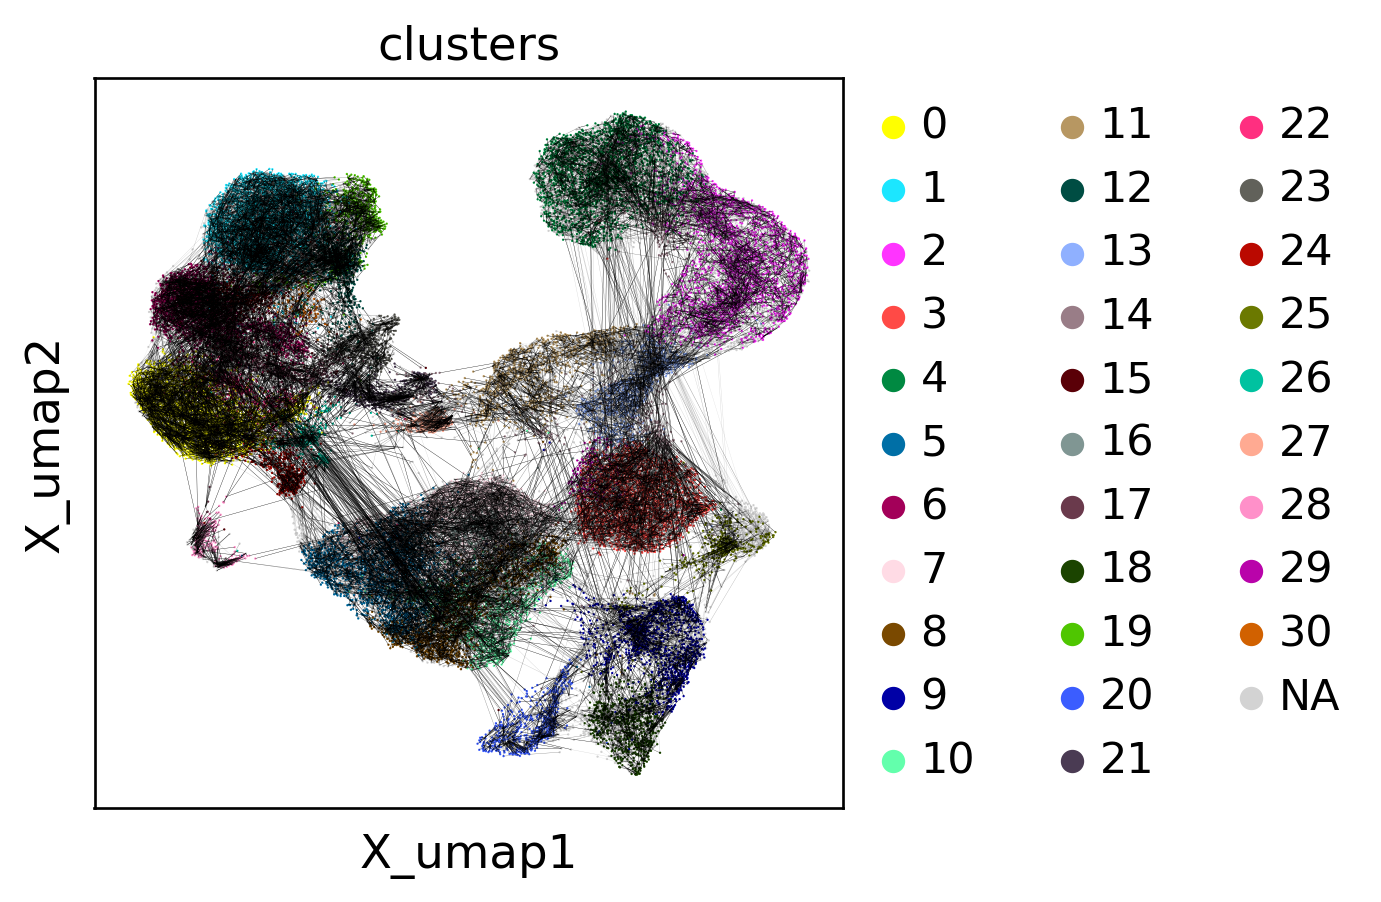

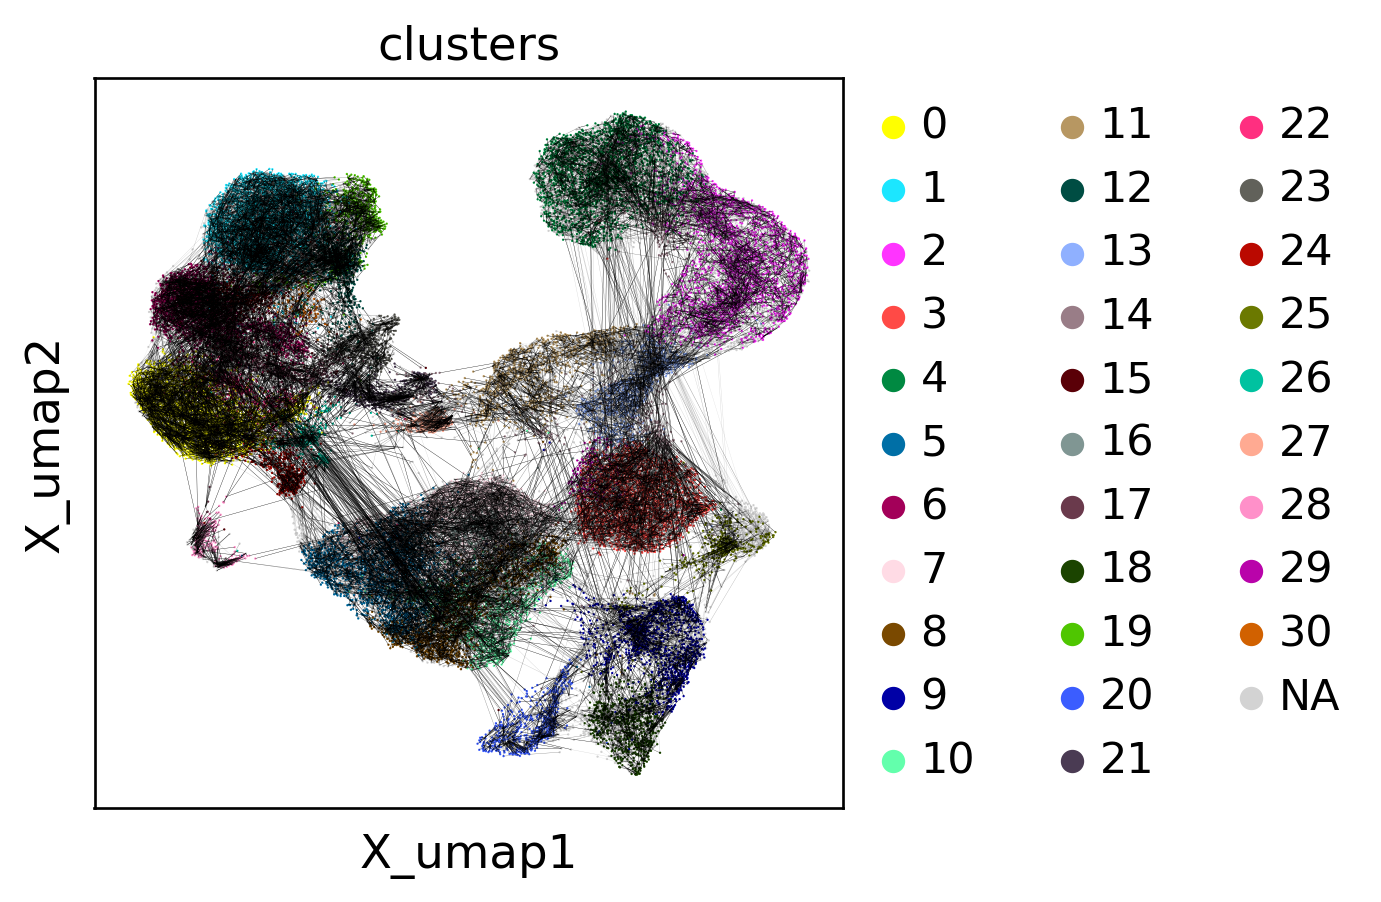

In [60]:
utils.visualize_neighbors(
        mod1=combined[combined.obs.tech=='rna'], mod2=combined[combined.obs.tech=='atac'],
        joint_embedding='X_umap',
        matching_matrix=matching_matrix,
        linewidths= 0.1, color='clusters'
) 

In [61]:
matching_matrix = matching_matrix.tocoo()
matches = [
    [rna.obs_names[row], atac.obs_names[col]]
    for row, col in zip(matching_matrix.row, matching_matrix.col)
]

In [63]:
matching = pd.DataFrame(matches, columns=['rna', 'atac'])

### Matching using Treutlein approach

#### Match cells using all rna cells

In [17]:
matching = pd.read_csv('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/matching_k15_99.tsv', sep='\t')

In [ ]:
combined.obs['matching_rna'] = ((combined.obs.tech =='rna') & (~combined.obs.index.isin(matching.rna)))*1

In [ ]:
combined.obs['matching_atac'] = ((combined.obs.tech =='atac') & (~combined.obs.index.isin(matching.atac)))*1

In [ ]:
sc.pl.umap(combined, color=['matching_rna', 'matching_atac', 'clusters', 'day'])

In [18]:
def add_dummy_cell(adata, index="None", value=0):
    dummy_cell = adata[0].copy()
    dummy_cell.obsm['activities'] = np.zeros(dummy_cell.obsm['activities'].shape)
    dummy_cell.obsm['chromvar'] = np.zeros(dummy_cell.obsm['chromvar'].shape)
    dummy_cell.obsm['X_glue'] = np.ones(dummy_cell.obsm['X_glue'].shape)*np.nan
    dummy_cell.obsm['atac_counts'] = np.zeros(dummy_cell.shape)
    dummy_cell.obs_names = [index]
    return anndata.concat([adata, dummy_cell], uns_merge='same')

In [19]:
atac_tmp = add_dummy_cell(atac)

In [20]:
metacells = rna[matching.rna]

In [25]:
metacells.obs['atac_match'] = pd.Series(1*(matching.atac != "None").values, index=metacells.obs_names)
metacells.obs['atac_barcode'] = pd.Series(matching.atac.values, index=metacells.obs_names)

In [27]:
atac_combined = atac_tmp[matching.atac]

In [28]:
del atac_tmp

In [29]:
metacells.obsm['activities'] = atac_combined.obsm['activities']
metacells.obsm['chromvar'] = atac_combined.obsm['chromvar']
metacells.obsm['atac_counts'] = atac_combined.X
metacells.uns['gene_names'] = atac_combined.uns['gene_names']
metacells.uns['motif_names'] = atac_combined.uns['motif_names']

In [30]:
metacells.uns['atac_peaks'] = atac_combined.var_names.values

In [31]:
metacells.layers = rna[matching.rna].layers

In [47]:
emb = np.nanmean(np.stack([metacells.obsm['X_glue'], atac_combined.obsm['X_glue']], axis=2), axis=2)

In [48]:
metacells.obsm['X_glue'] = emb

In [34]:
sc.pp.neighbors(metacells, use_rep="X_glue", random_state=0)

In [35]:
sc.tl.umap(metacells, random_state=1)

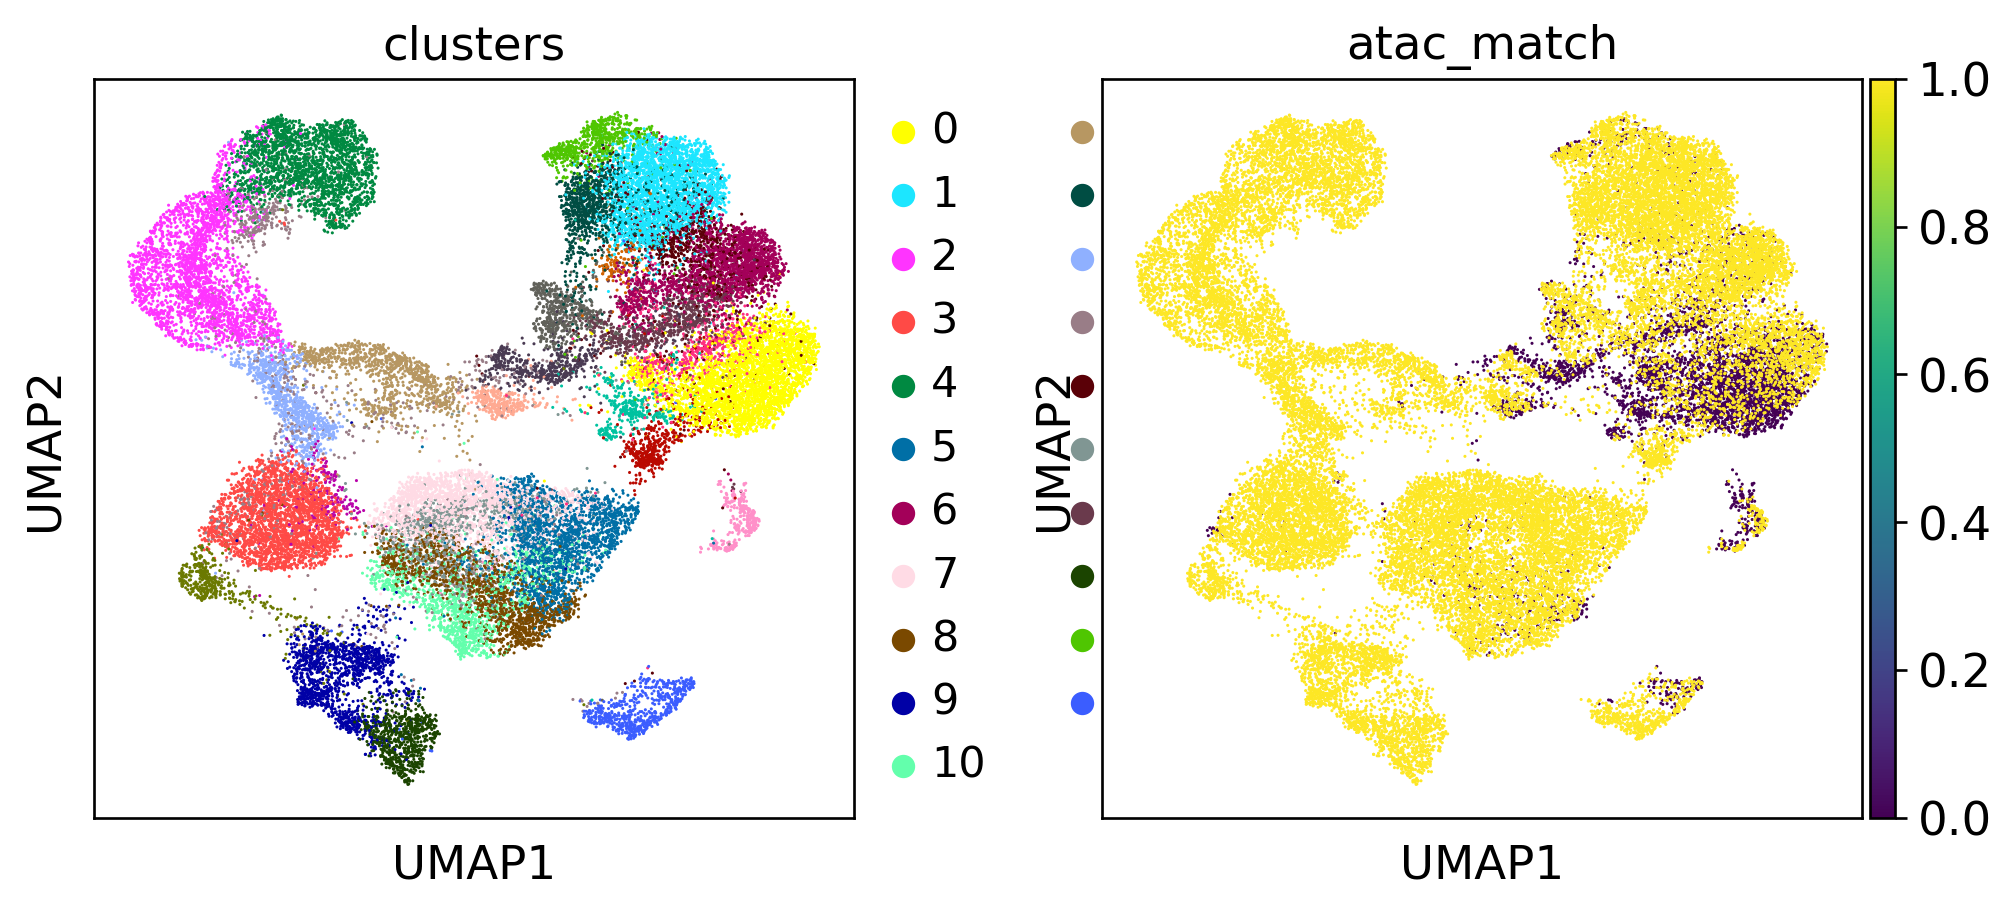

In [36]:
sc.pl.umap(metacells, color=['clusters', 'atac_match'])

In [32]:
metacells_old = sc.read('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/metacells.h5ad')

In [33]:
metacells.obsm['X_glue'] = metacells_old.obsm['X_glue']

### Matching using not all rna cells

In [79]:
matching = pd.read_csv('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/matching_k15_n99.tsv', sep='\t')

In [80]:
metacells = rna[matching.rna].copy()

In [81]:
metacells

AnnData object with n_obs × n_vars = 30638 × 24171
    obs: 'clusters', 'day', 'tech'
    var: 'gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'transcript_id', 'gene_type', 'gene_status', 'transcript_type', 'transcript_status', 'transcript_name', 'havana_gene', 'tag'
    uns: 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_glue'
    varm: 'PCs'
    layers: 'counts', 'log_counts'
    obsp: 'connectivities', 'distances'

In [82]:
atac_combined = atac[matching.atac].copy()

/home/icb/laura.martens/miniconda3/envs/cellrank/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [83]:
metacells.obsm['activities'] = atac_combined.obsm['activities']
metacells.obsm['chromvar'] = atac_combined.obsm['chromvar']
metacells.uns['gene_names'] = atac_combined.uns['gene_names']
metacells.uns['motif_names'] = atac_combined.uns['motif_names']

In [84]:
metacells.layers = rna[matching.rna].layers

In [85]:
emb = np.mean(np.stack([metacells.obsm['X_glue'], atac_combined.obsm['X_glue']], axis=2), axis=2)

In [86]:
metacells.obsm['X_glue'] = emb

In [87]:
sc.pp.neighbors(metacells, use_rep="X_glue", random_state=0)

In [99]:
sc.tl.umap(metacells, random_state=2)

In [92]:
metacells.shape

(30638, 24171)

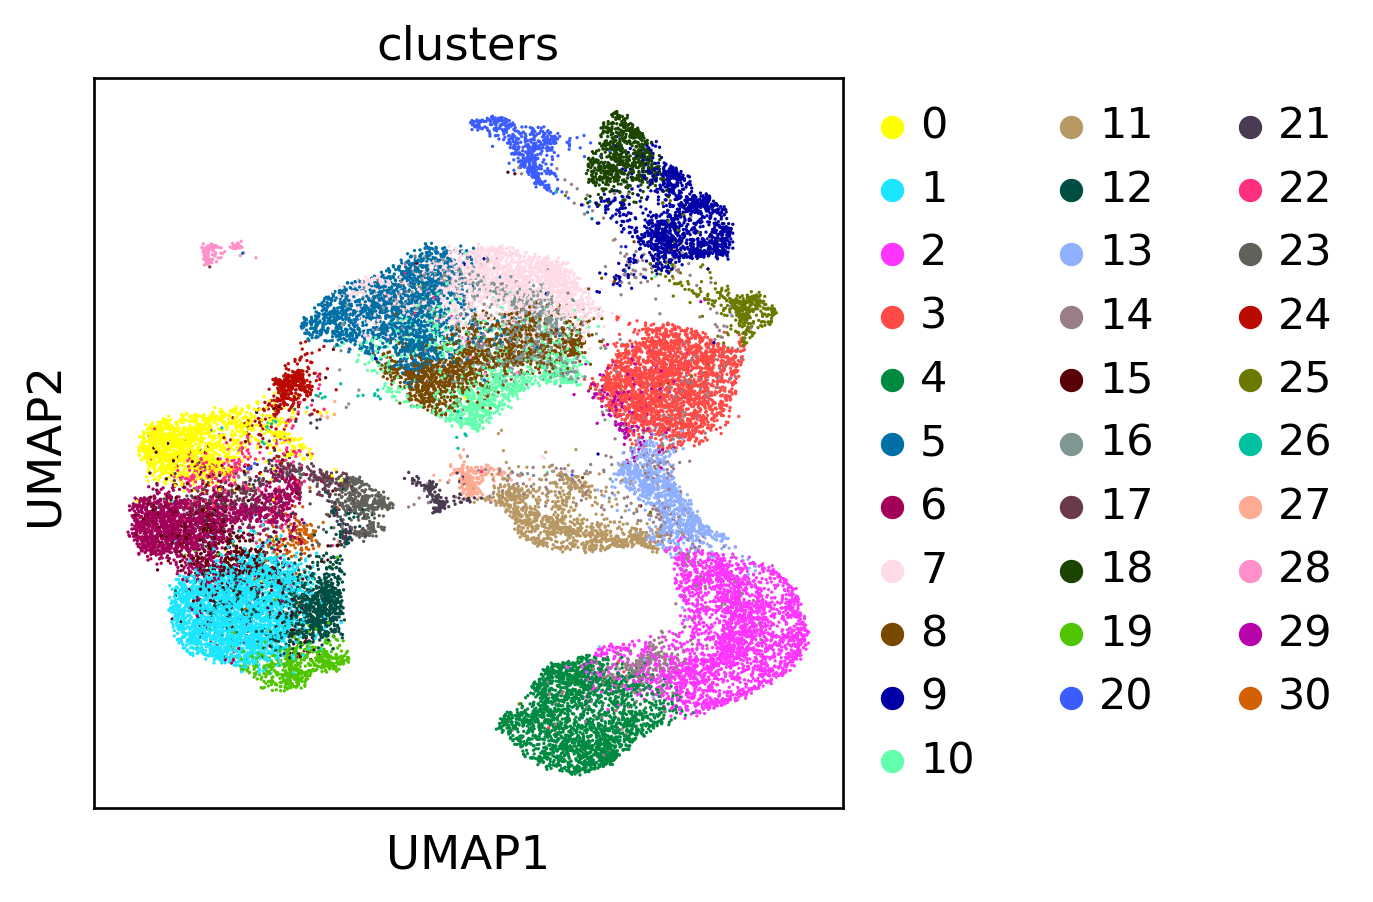

In [100]:
sc.pl.umap(metacells, color=['clusters'])

## Intermediate save

In [37]:
metacells.write('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/metacells.h5ad')

In [46]:
combined.write('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/combined.h5ad')

# Save cluster atac matching

In [1]:
import scanpy as sc
import pandas as pd

In [2]:
metacells = sc.read('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/metacells.h5ad')

In [3]:
matching = pd.read_csv('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/matching_k15_99.tsv', sep='\t')

In [4]:
matching

rna                atac
0      AAACCCAAGAGCAAGA-1_5                None
1      AAACCCAAGCCGCACT-1_7  CAGCCTTTCACAACAC-7
2      AAACCCAAGCCGTTGC-1_5                None
3      AAACCCAAGCGAGAAA-1_6  TACTGCCAGAGCCTGA-3
4      AAACCCAAGCTCCATA-1_1  GAACCGCTCCGTTTCG-1
...                     ...                 ...
35494  TTTGTTGTCGGATACT-1_5                None
35495  TTTGTTGTCGTCAAAC-1_4  GCCTACTGTCTAAAGA-2
35496  TTTGTTGTCGTTCCCA-1_5                None
35497  TTTGTTGTCTCTCTAA-1_6  TCCGACTTCCATTGTT-6
35498  TTTGTTGTCTTAGGAC-1_1  GCTCCTACATCCCTCA-1

[35499 rows x 2 columns]

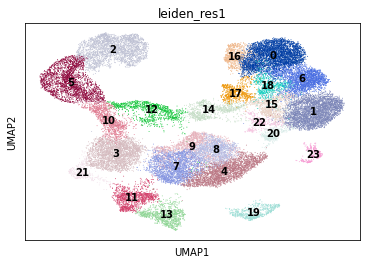

In [15]:
sc.pl.umap(metacells, color='leiden_res1', legend_loc='on data')

In [13]:
metacells.obs = metacells.obs.join(pd.Series(matching.atac.values, index=matching['rna'].values, name='atac_barcode'))

In [80]:
metacells.write('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/metacells.h5ad')

In [11]:
metadata = metacells.obs[['leiden_res1', 'day']]

In [15]:
metadata = metadata.join(matching.set_index('rna'))

In [24]:
metadata = metadata[metadata.atac != 'None'].set_index('atac')

In [29]:
metadata.to_csv(os.path.join(save_path, 'metadata_atac_tobias.csv'))

In [30]:
save_path

'/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue'